# Import dependencies

In [1]:
try:
  import cleverhans
except ImportError:
  ! pip install cleverhans

     |████████████████████████████████| 204kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 2.5MB 32.3MB/s eta 0:00:01
  Stored in directory: /Users/haekyu/Library/Caches/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 1.14.0 requires google-pasta>=0.1.6, which is not installed.
ERROR: spyder 3.3.6 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 3.3.6 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2
  Found existing installation: cloudpickle 1.2.1
    Uninstalling cloudpickle-1.2.1:
      Successfully uninstalled cloudpickle-1.2.1


In [2]:
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.model import Model as CleverhansModel
from io import BytesIO
import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Define model wrapper for cleverhans

In [4]:
class InceptionV1Model(CleverhansModel):
  SCOPE = 'inceptionv1'
  SOFTMAX_OP = 'softmax2'
  
  def __init__(self):
    super(InceptionV1Model, self).__init__()
    self._model = models.InceptionV1()
    self._model.load_graphdef()

    self._fprop_cache = dict()

  def fprop(self, x):
    if x not in self._fprop_cache:
      # https://github.com/tensorflow/lucid/blob/67e19f38c315e548034c3e4315dfee6f718df916/lucid/modelzoo/vision_base.py#L189
      graph = x.graph
      scope = graph.unique_name(
          '%sfprop%d' % (self.SCOPE, len(self._fprop_cache)), False)
      _, x_prep = self._model.create_input(x, forget_xy_shape=True)
      final_input_map = {self._model.input_name: x_prep}
      ops = tf.import_graph_def(self._model.graph_def, final_input_map,
                                return_elements=[self.SOFTMAX_OP], name=scope)
      self._model.post_import(scope)
      
      softmax2_op = ops[0]
      logits = softmax2_op.inputs[0]
      logits = logits[:, :1000]

      self._fprop_cache[x] = {'logits' : logits}

    return self._fprop_cache[x]

# Define utility functions

In [5]:
def load_image_from_url(img_url, resize_to=(224, 224)):
  img_response = requests.get(img_url)
  img = Image.open(BytesIO(img_response.content))
  if resize_to is not None:
    img = img.resize(resize_to)
  img = np.array(img)
  return img

In [6]:
def load_image_from_file(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [7]:
def get_predictions(model, imgs):
  graph = tf.Graph()
  with tf.Session(graph=graph) as sess:  
    x = tf.placeholder(tf.float32, (None, 224, 224, 3))
    y = model.get_probs(x)
    y = tf.arg_max(y, 1)
    y_eval = sess.run(y, feed_dict={x: imgs})
  
  return y_eval

In [8]:
def attack_images(model, imgs):
  graph = tf.Graph()
  with tf.Session(graph=graph) as sess:
    x = tf.placeholder(tf.float32, (None, 224, 224, 3))

    attack = ProjectedGradientDescent(model, sess=sess)
    attack_kwargs = {'eps': 16, 'eps_iter': 1.0, 'nb_iter': 20}
    
    adv_imgs = attack.generate(x, **attack_kwargs)
    adv_imgs_eval = sess.run(adv_imgs, feed_dict={x: imgs})

  return adv_imgs_eval

# Initialize model and load image

In [9]:
model = InceptionV1Model()

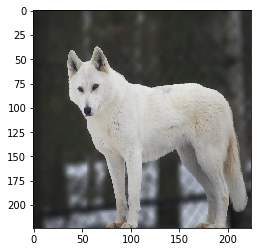

In [10]:
# Get an input image from url
img_url = ('https://images.fineartamerica.com/images/artworkimages'
           '/mediumlarge/1/white-wolf-elaine-mikkelstrup.jpg')

img = load_image_from_url(img_url)
plt.imshow(img)

'''
# Get an input image from file
image_path = './cat-salt.jpeg'

print('Raw image')
plt.figure()
raw_input_imgage = plt.imread(image_path)
plt.imshow(raw_input_imgage)
plt.show()

print('Processed image')
img = load_image_from_file(image_path)
plt.imshow(img)
'''
print()

# Experiments

## Get prediction on benign image

In [11]:
get_predictions(model, [img]) # 102 -> white_wolf

array([102])

## Generate attacked image

In [12]:
adv_imgs = attack_images(model, [img])

adv_img = adv_imgs[0]
plt.imshow(np.array(adv_img, dtype=np.uint8))

AbortedError: Operation received an exception:Status: 5, message: could not create a view primitive descriptor, in file tensorflow/core/kernels/mkl_slice_op.cc:433
	 [[node while/gradients/while/while/inceptionv1fprop2/mixed4a_grad/Slice_2 (defined at /Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:469) ]]

Original stack trace for 'while/gradients/while/while/inceptionv1fprop2/mixed4a_grad/Slice_2':
  File "/Users/haekyu/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/haekyu/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/haekyu/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/Users/haekyu/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/Users/haekyu/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-7e3ab52a818a>", line 1, in <module>
    adv_imgs = attack_images(model, [img])
  File "<ipython-input-8-9c73f21a5b90>", line 9, in attack_images
    adv_imgs = attack.generate(x, **attack_kwargs)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 613, in generate
    _, adv_x = tf.while_loop(cond, body, [tf.zeros([]), adv_x], back_prop=True)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3501, in while_loop
    return_same_structure)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3012, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2937, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 598, in body
    adv_x = FGM.generate(adv_x, **fgm_params)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 353, in generate
    sanity_checks=self.sanity_checks)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 469, in fgm
    grad, = tf.gradients(loss, x)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 158, in gradients
    unconnected_gradients)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py", line 731, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py", line 403, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py", line 731, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py", line 219, in _ConcatGrad
    dim_index=0)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py", line 153, in _ConcatGradHelper
    out_grads.append(array_ops.slice(grad, begin, size))
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 733, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8823, in _slice
    "Slice", input=input, begin=begin, size=size, name=name)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'while/while/inceptionv1fprop2/mixed4a', defined at:
  File "/Users/haekyu/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 32 identical lines from previous traceback]
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 598, in body
    adv_x = FGM.generate(adv_x, **fgm_params)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/attacks/__init__.py", line 346, in generate
    self.model.get_logits(x),
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/cleverhans/model.py", line 65, in get_logits
    outputs = self.fprop(x, **kwargs)
  File "<ipython-input-4-6fa920add5e2>", line 21, in fprop
    return_elements=[self.SOFTMAX_OP], name=scope)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/importer.py", line 443, in import_graph_def
    _ProcessNewOps(graph)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/importer.py", line 236, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3751, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3751, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3641, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/Users/haekyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


## Get prediction on adversarial image

In [ ]:
get_predictions(model, [adv_img])

array([46])